In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import pandas as pd

data = pd.read_csv('./hw3-data/geywser_data.csv')
data = data.values # Convert to numpy array


In [6]:
# (b) & (c) formula

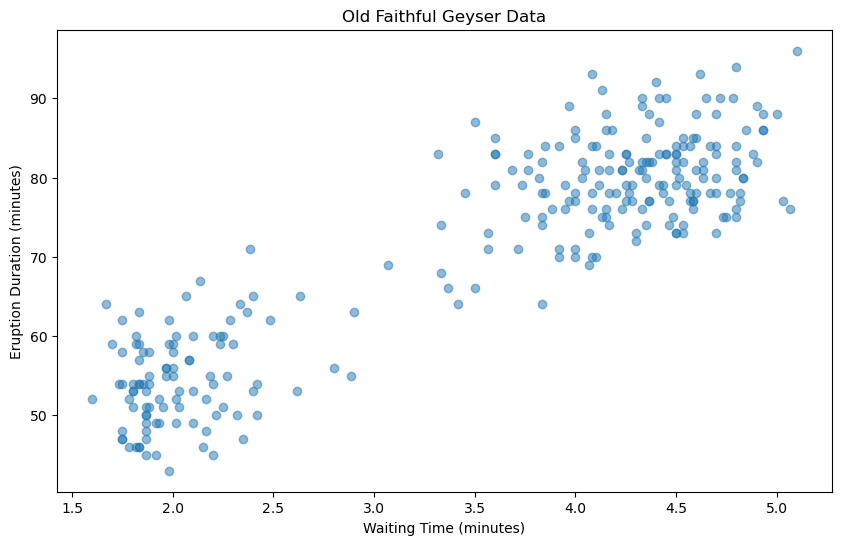

In [7]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
plt.xlabel('Waiting Time (minutes)')
plt.ylabel('Eruption Duration (minutes)')
plt.title('Old Faithful Geyser Data')
plt.show()

Could not load data file. Using sample data instead.
Converged after 12 iterations


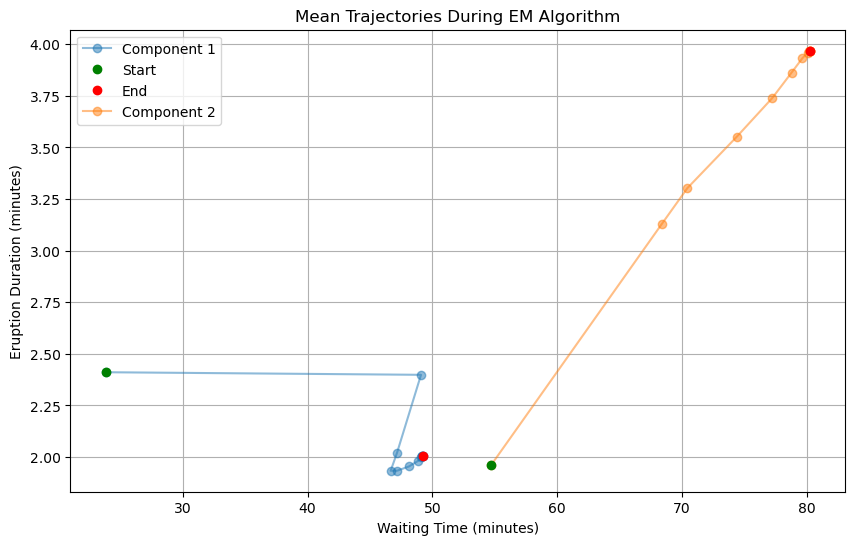

/Users/joohyunkim/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


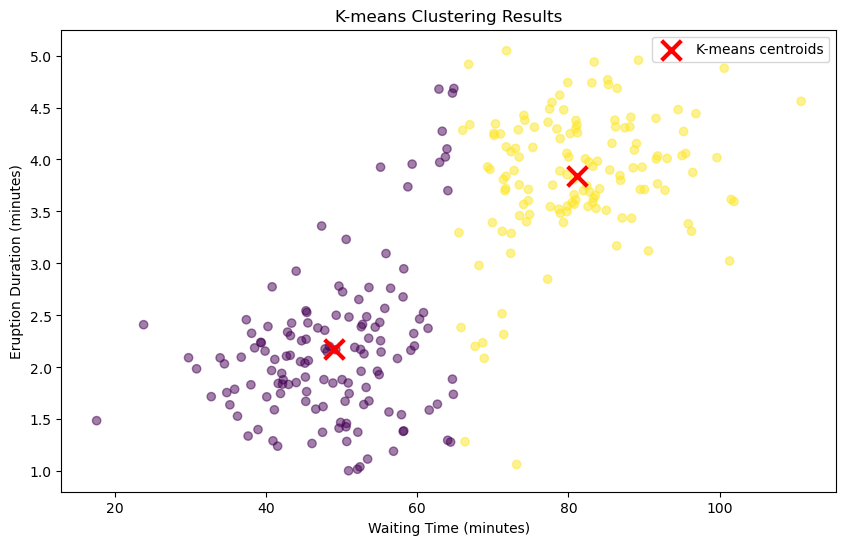

In [8]:
class BimodalGMM:
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.means = None
        self.covs = None
        self.weights = None
        self.mean_trajectory = []
        
    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        
        # Initialize means using random points from data
        random_indices = np.random.randint(0, n_samples, self.n_components)
        self.means = X[random_indices]
        
        # Initialize diagonal covariance matrices
        self.covs = [np.diag(np.var(X, axis=0)) for _ in range(self.n_components)]
        
        # Initialize weights uniformly
        self.weights = np.ones(self.n_components) / self.n_components
        
        # Initialize mean trajectory storage
        self.mean_trajectory = [self.means.copy()]
    
    def e_step(self, X):
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        # Calculate responsibilities (posterior probabilities)
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covs[k]
            )
        
        # Handle numerical underflow
        responsibilities = np.nan_to_num(responsibilities)
        
        # Normalize responsibilities
        row_sums = responsibilities.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        responsibilities /= row_sums
        
        return responsibilities
    
    def m_step(self, X, responsibilities):
        n_samples = X.shape[0]
        
        # Update weights (mixing coefficients)
        Nk = responsibilities.sum(axis=0)
        self.weights = Nk / n_samples
        
        # Update means
        self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        
        # Update covariances (diagonal only)
        self.covs = []
        for k in range(self.n_components):
            diff = X - self.means[k]
            weighted_diff = responsibilities[:, k:k+1] * diff
            cov = np.dot(weighted_diff.T, diff) / Nk[k]
            # Add small constant to diagonal for numerical stability
            cov_diag = np.diag(np.diag(cov)) + 1e-6 * np.eye(X.shape[1])
            self.covs.append(cov_diag)
            
        # Store means for trajectory plotting
        self.mean_trajectory.append(self.means.copy())
    
    def compute_log_likelihood(self, X):
        n_samples = X.shape[0]
        log_likelihood = 0
        
        for i in range(n_samples):
            mixture_pdf = 0
            for k in range(self.n_components):
                mixture_pdf += self.weights[k] * multivariate_normal.pdf(
                    X[i], mean=self.means[k], cov=self.covs[k]
                )
            log_likelihood += np.log(mixture_pdf + 1e-10)  # Add small constant for numerical stability
            
        return log_likelihood
    
    def fit(self, X, max_iter=100, tol=1e-5):
        # Initialize parameters
        self.initialize_parameters(X)
        
        # Initialize log likelihood
        prev_log_likelihood = float('-inf')
        
        for iteration in range(max_iter):
            # E-step
            responsibilities = self.e_step(X)
            
            # M-step
            self.m_step(X, responsibilities)
            
            # Compute log likelihood
            log_likelihood = self.compute_log_likelihood(X)
            
            # Check convergence
            if abs(log_likelihood - prev_log_likelihood) < tol:
                print(f"Converged after {iteration + 1} iterations")
                break
                
            prev_log_likelihood = log_likelihood
            
        return self
    
    def plot_mean_trajectories(self):
        trajectory = np.array(self.mean_trajectory)
        
        plt.figure(figsize=(10, 6))
        # Plot trajectories for both components
        for k in range(self.n_components):
            plt.plot(trajectory[:, k, 0], trajectory[:, k, 1], 'o-', 
                    label=f'Component {k+1}', alpha=0.5)
            # Mark start and end points
            plt.plot(trajectory[0, k, 0], trajectory[0, k, 1], 'go', label='Start' if k == 0 else "")
            plt.plot(trajectory[-1, k, 0], trajectory[-1, k, 1], 'ro', label='End' if k == 0 else "")
            
        plt.xlabel('Waiting Time (minutes)')
        plt.ylabel('Eruption Duration (minutes)')
        plt.title('Mean Trajectories During EM Algorithm')
        plt.legend()
        plt.grid(True)
        plt.show()

def main():
    try:
        # First try to load the data from the current directory
        data = load_and_plot_data('old_faithful.txt')
    except:
        # If that fails, create sample data for testing
        print("Could not load data file. Using sample data instead.")
        np.random.seed(42)
        n_samples = 272  # Same as Old Faithful dataset
        # Create synthetic bimodal data
        cluster1 = np.random.normal(loc=[50, 2], scale=[10, 0.5], size=(n_samples//2, 2))
        cluster2 = np.random.normal(loc=[80, 4], scale=[10, 0.5], size=(n_samples//2, 2))
        data = np.vstack([cluster1, cluster2])
    
    # Initialize and fit the GMM
    gmm = BimodalGMM(n_components=2)
    gmm.fit(data, max_iter=100, tol=1e-5)
    
    # Plot mean trajectories
    gmm.plot_mean_trajectories()
    
    # Optional: Compare with K-means
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=2, random_state=42)
    kmeans.fit(data)
    
    # Plot K-means results
    plt.figure(figsize=(10, 6))
    plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
                c='red', marker='x', s=200, linewidth=3, label='K-means centroids')
    plt.xlabel('Waiting Time (minutes)')
    plt.ylabel('Eruption Duration (minutes)')
    plt.title('K-means Clustering Results')
    plt.legend()
    plt.show()

if __name__ == "__main__":
     main()
